In [1]:
import os
import mne
import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from src.data.utils.eeg import get_raw
from src.data.processing import load_data_dict, get_data
from src.data.conf.eeg_annotations import braincapture_annotations

In [2]:
import logging

# Suppress logger messages from MNE-Python
mne_logger = logging.getLogger('mne')
mne_logger.setLevel(logging.ERROR)

In [3]:
os.chdir("/home/jupyter")
braincapture_data_folder = r'copenhagen_medtech_hackathon/BrainCapture Dataset/'

subject_folders = os.listdir(braincapture_data_folder)
number_files = np.sum([len(os.listdir(braincapture_data_folder + folder)) for folder in subject_folders])

print('The BrainCapture dataset contains', len(subject_folders), 'subject folders and', number_files, 'files!')

The BrainCapture dataset contains 133 subject folders and 136 files!


**Load labeled BrainCapture data**

In [ ]:
data_dict = load_data_dict(data_folder_path=braincapture_data_folder, annotation_dict=braincapture_annotations, tmin=-0.5, tlen=6, labels=True)

 75%|███████▌  | 100/133 [01:50<00:34,  1.05s/it]

In [ ]:
all_subjects = list(data_dict.keys())

X_labeled, y = get_data(data_dict, all_subjects)
print('X shape:', X_labeled.shape)
print('y shape:', y.shape)

In [ ]:
os.chdir("/home/jupyter/GoogleBrainCaptureHackathon")

torch.save(X_labeled, "X_bc_data_labeled.pt")
torch.save(y, "y_bc_data_labeled.pt")

**Load unlabeled BrainCapture data**

In [ ]:
os.chdir("/home/jupyter")
data_dict = load_data_dict(data_folder_path=braincapture_data_folder, annotation_dict=braincapture_annotations, tmin=-0.5, tlen=6, labels=False)

100%|██████████| 133/133 [02:35<00:00,  1.17s/it]


In [ ]:
all_subjects = list(data_dict.keys())

X_unlabeled = get_data(data_dict, all_subjects)
print('X shape:', X_unlabeled.shape)

/home/jupyter/GoogleBrainCaptureHackathon/src/data/processing.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = [torch.tensor(data_dict[subject][session]['X']) for subject in subject_list for session in data_dict[subject].keys()]


X shape: torch.Size([44184, 20, 1536])


In [ ]:
os.chdir("/home/jupyter/GoogleBrainCaptureHackathon")

torch.save(X_unlabeled, "X_bc_data_unlabeled.pt")

**Generate latent representations**

In [ ]:
import os
import numpy as np
from copy import deepcopy
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from sklearn.decomposition import PCA

from model import BendrEncoder
from model.model import Flatten

from src.data.conf.eeg_annotations import braincapture_annotations

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [ ]:
import logging

# Suppress logger messages from MNE-Python
mne_logger = logging.getLogger('mne')
mne_logger.setLevel(logging.ERROR)

In [ ]:
# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
encoder = BendrEncoder()

# Load the pretrained model
encoder.load_state_dict(deepcopy(torch.load("encoder.pt", map_location=device)))
encoder = encoder.to(device)

In [ ]:
def generate_latent_representations(data, encoder, batch_size=5):
    """ Generate latent representations for the given data using the given encoder.
    Args:
        data (np.ndarray): The data to be encoded.
        encoder (nn.Module): The encoder to be used.
        batch_size (int): The batch size to be used.
    Returns:
        np.ndarray: The latent representations of the given data.
    """
    latent_size = (1536, 4) # do not change this 
    latent = np.empty((data.shape[0], *latent_size))

    for i in tqdm(range(0, data.shape[0], batch_size)):
        latent[i:i+batch_size] = encoder(data[i:i+batch_size]).cpu().detach().numpy()

    return latent.reshape((latent.shape[0], -1))

In [ ]:
out_features = 5

linear_head = nn.Sequential(
    encoder,
    Flatten(),
    nn.Linear(in_features = 3 * 512 * 4, out_features = 512 * 4, bias=True),
    nn.Dropout(p=0.4, inplace=False),
    nn.ReLU(),
    nn.BatchNorm1d(512 * 4),
    nn.Linear(512 * 4, out_features, bias=True) 
)

linear_head = linear_head.to(device)
linear_head = linear_head.train()

# Lock encoder parameters from training
# for param in model[0].parameters():
#     param.requires_grad = False

In [ ]:
def finetune_model(model, train_loader, criterion, optimizer, scheduler, n_epochs, device):

    for epoch in range(1, n_epochs + 1):
        total = correct = 0
        pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch}, train")
        for batch in train_loader:
            if len(batch[0]) < 2: continue            
            
            optimizer.zero_grad()
                    
            X, y = batch
            X, y = X.to(device), y.to(device)
            logits = model(X)       
            _, predicted = torch.max(logits.data, 1)

            total += y.size(0)
            correct += (predicted == y).sum().item()
            
            loss = criterion(logits, y)
            loss.backward()

            optimizer.step()
            scheduler.step()
            
            pbar.update(1)

        train_accuracy = np.round(100 * correct / total, 2)
        pbar.set_description(f"Epoch {epoch}, train accuracy: {train_accuracy}%")

def evaluate_model(model, test_loader, device, optimizer):
    with torch.no_grad():
        model.eval()
        total = correct = 0
        pbar = tqdm(total=len(test_loader), desc=f"Testing...")
        for batch in test_loader:
            if len(batch[0]) < 2: continue            
            
            optimizer.zero_grad()
                    
            X, y = batch
            X, y = X.to(device), y.to(device)

            logits = model(X)
            _, predicted = torch.max(logits.data, 1)

            total += y.size(0)
            correct += (predicted == y).sum().item()
            pbar.update(1)
            
        pbar.set_description(f"Test accuracy: {100 * correct / total:2f}%") 

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X_labeled, y)

batch_size = 4
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

learning_rate = 0.0001
n_epochs = 10 # you can increase this number

optimizer = torch.optim.SGD(linear_head.parameters(), lr=learning_rate, weight_decay=0.01, momentum=0.9, nesterov=True)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=learning_rate, epochs=n_epochs, steps_per_epoch=len(train_loader), pct_start=0.1, last_epoch=-1
)

In [ ]:
# train the model
finetune_model(linear_head, train_loader, criterion, optimizer, scheduler, n_epochs, device)

Epoch 1, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 2, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 3, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 4, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 5, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 6, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 7, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 8, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 9, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 10, train:   0%|          | 0/115 [00:00<?, ?it/s]

In [ ]:
# evaluate the model
evaluate_model(linear_head, test_loader, device, optimizer)

Testing...:   0%|          | 0/29 [00:00<?, ?it/s]

In [ ]:
# generate finetuned encodings of the labeled data
finetuned_latent_representations = generate_latent_representations(X_labeled.to(device), encoder)
np.savez('finetuned_latent_representations_labeled.npz', finetuned_latent_representations)

  0%|          | 0/115 [00:00<?, ?it/s]

In [ ]:
# generate finetuned encodings of the unlabeled data
finetuned_latent_representations_unlabeled = generate_latent_representations(X_unlabeled.cpu(), encoder.cpu())
np.savez('finetuned_latent_representations_unlabeled.npz', finetuned_latent_representations_unlabeled)

  0%|          | 0/8837 [00:00<?, ?it/s]

**Train models and predict labels for unlabeled data**

In [224]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from src.data.conf.eeg_annotations import braincapture_annotations

In [225]:
os.chdir("/home/jupyter/GoogleBrainCaptureHackathon")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X = np.load('finetuned_latent_representations_labeled.npz')
X = X['arr_0']
y = torch.load("y_bc_data_labeled.pt").to(device).long()
print(X.shape)

X_unlabeled = np.load('finetuned_latent_representations_unlabeled.npz')
X_unlabeled = X_unlabeled['arr_0']
print(X_unlabeled.shape)

(575, 6144)
(44184, 6144)


In [226]:
# split data in training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train:', X_train.shape)
print('X_test: ', X_test.shape)

X_train: (460, 6144)
X_test:  (115, 6144)


In [227]:
# instantiate and train a logistic regressor
logreg = LogisticRegression().fit(torch.tensor(X_train).cpu(), torch.tensor(y_train).cpu())

# score the model on the test set
logreg.score(torch.tensor(X_test).cpu(), torch.tensor(y_test).cpu())

/var/tmp/ipykernel_207068/3060884778.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logreg = LogisticRegression().fit(torch.tensor(X_train).cpu(), torch.tensor(y_train).cpu())
/var/tmp/ipykernel_207068/3060884778.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logreg.score(torch.tensor(X_test).cpu(), torch.tensor(y_test).cpu())


0.8347826086956521

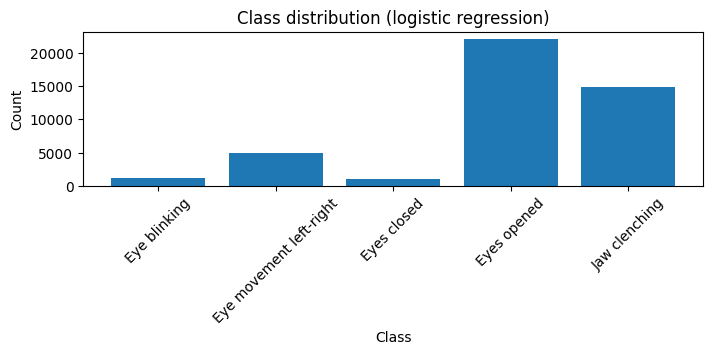

In [228]:
new_preds = logreg.predict(torch.tensor(X_unlabeled).cpu())
unique, counts = np.unique(new_preds, return_counts=True)

fig, ax = plt.subplots(figsize=(8, 2))

ax.bar(unique, counts, align='center')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class distribution (logistic regression)')
ax.set_xticks(unique)
ax.set_xticklabels(braincapture_annotations.keys(), rotation=45)

plt.savefig('distr_logreg.png', bbox_inches = "tight")
plt.show()

In [229]:
# instantiate and train a multi-layer perceptron
mlp = MLPClassifier(random_state=1, max_iter=500).fit(torch.tensor(X_train).cpu(), torch.tensor(y_train).cpu())

# score the model on the test set
mlp.score(torch.tensor(X_test).cpu(), torch.tensor(y_test).cpu())

/var/tmp/ipykernel_207068/131702505.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mlp = MLPClassifier(random_state=1, max_iter=500).fit(torch.tensor(X_train).cpu(), torch.tensor(y_train).cpu())
/var/tmp/ipykernel_207068/131702505.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mlp.score(torch.tensor(X_test).cpu(), torch.tensor(y_test).cpu())


0.7565217391304347

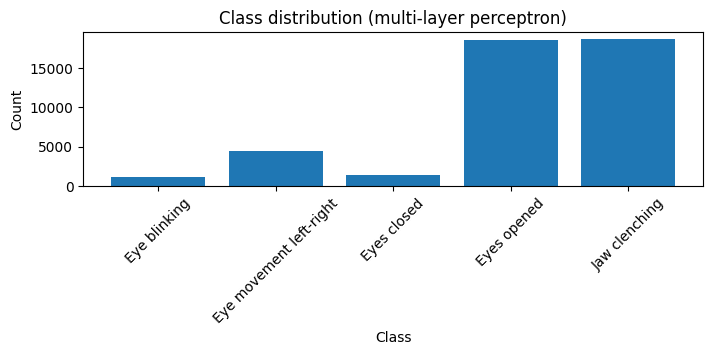

In [230]:
new_preds = mlp.predict(X_unlabeled)
unique, counts = np.unique(new_preds, return_counts=True)

fig, ax = plt.subplots(figsize=(8, 2))

ax.bar(unique, counts, align='center')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class distribution (multi-layer perceptron)')
ax.set_xticks(unique)
ax.set_xticklabels(braincapture_annotations.keys(), rotation=45)

plt.savefig('distr_mlp.png', bbox_inches = "tight")
plt.show()

In [231]:
from braindecode import EEGClassifier
from torch.nn import CrossEntropyLoss
from skorch.dataset import ValidSplit
from skorch.callbacks import Checkpoint

os.chdir("/home/jupyter/GoogleBrainCaptureHackathon")
cp = Checkpoint(dirname='checkpoint/', f_params='best_model.pth')

net = EEGClassifier(
    'ShallowFBCSPNet',
    module__final_conv_length='auto',
    module__n_times=1536,
    module__n_chans=20,
    module__n_outputs=5,
    criterion = CrossEntropyLoss(),
    max_epochs=100,
    batch_size=8,
    train_split=ValidSplit(0.15),
    callbacks=[cp],
    optimizer = torch.optim.AdamW,
    optimizer__lr=0.0002, 
    optimizer__betas=(0.5, 0.999),
    device = "cuda",
)

net.initialize()
net.load_params('checkpoint/best_model.pth')

/opt/conda/lib/python3.10/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [232]:
os.chdir("/home/jupyter")
X_unlabeled = torch.load('GoogleBrainCaptureHackathon/X_bc_data_unlabeled.pt')
print(X_unlabeled.shape)

torch.Size([44184, 20, 1536])


In [233]:
info = mne.create_info(ch_names=20, sfreq=256, ch_types='eeg')
unlabeled_epochs = mne.EpochsArray(X_unlabeled, info=info)
probs = net.predict_proba(unlabeled_epochs)
new_preds = np.array(probs)
annotations = new_preds.argmax(axis=-1)

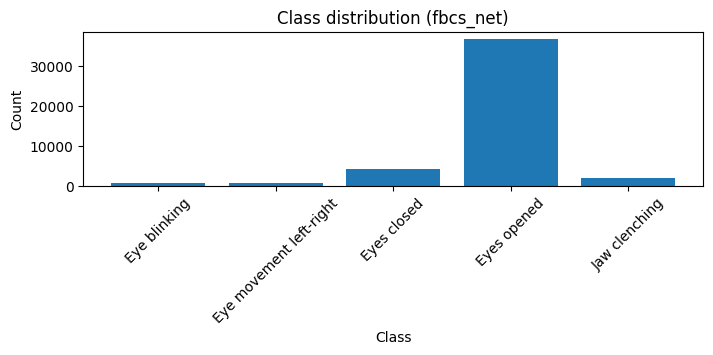

In [234]:
os.chdir("/home/jupyter/GoogleBrainCaptureHackathon")
unique, counts = np.unique(annotations, return_counts=True)

fig, ax = plt.subplots(figsize=(8, 2))

ax.bar(unique, counts, align='center')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class distribution (fbcs_net)')
ax.set_xticks(unique)
ax.set_xticklabels(braincapture_annotations.keys(), rotation=45)

plt.savefig('distr_fbcs_net.png', bbox_inches = "tight")
plt.show()

In [235]:
braincapture_annotations = {'Eye blinking': 0, 'Eye movement left-right': 1, 'Eyes closed': 2, 'Eyes opened': 3, 'Jaw clenching': 4}
print(braincapture_annotations)

{'Eye blinking': 0, 'Eye movement left-right': 1, 'Eyes closed': 2, 'Eyes opened': 3, 'Jaw clenching': 4}


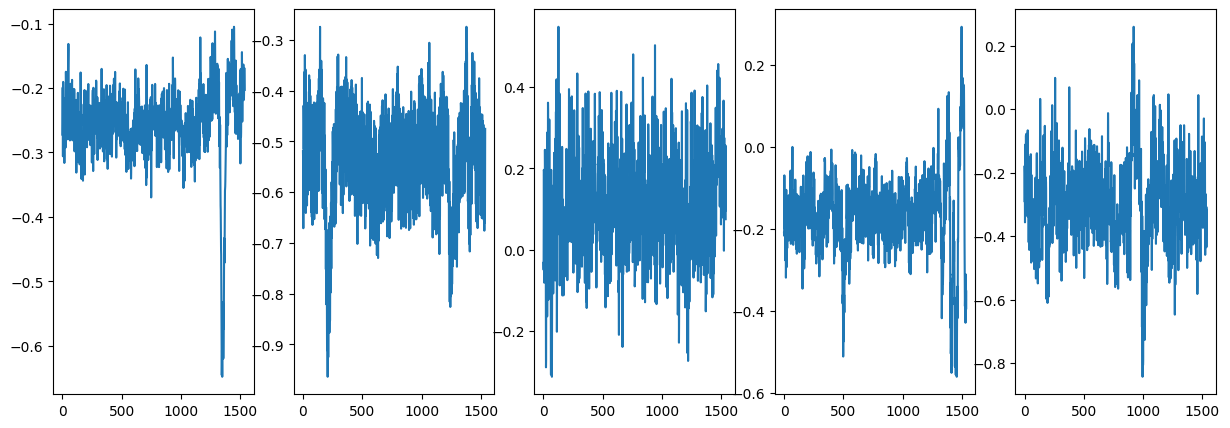

In [236]:
idx = np.where(y.cpu().numpy() == 3)
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

# Plot each subplot
for i in range(5):
    axs[i].plot(X_labeled[idx[0][i], -2])

plt.savefig('eyes_opened_labeled.png', bbox_inches = "tight")
plt.show()

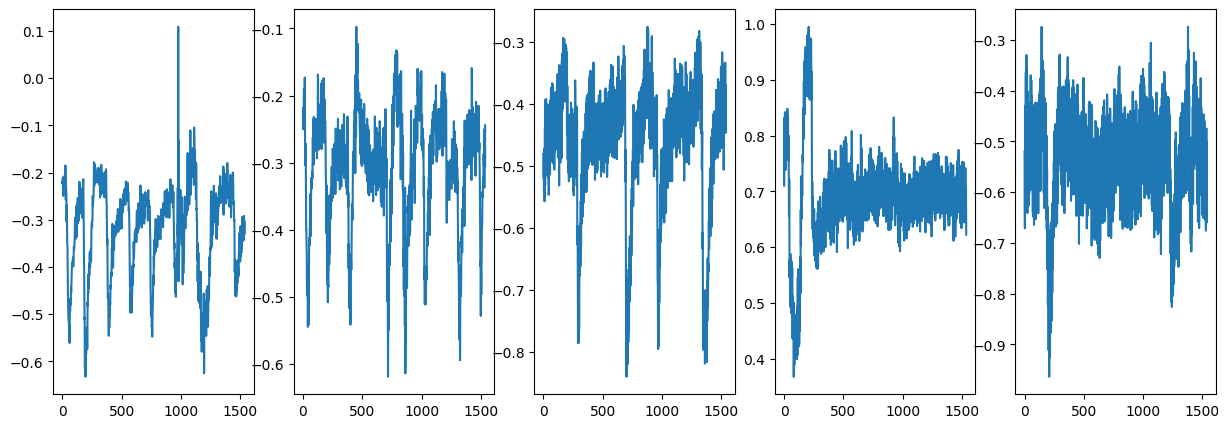

In [237]:
idx = np.where(annotations == 3)
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

# Plot each subplot
for i in range(5):
    axs[i].plot(X_labeled[idx[0][i], -2])

plt.savefig('eyes_opened_unlabeled.png', bbox_inches = "tight")
plt.show()

In [238]:
categories = ['Eye blinking', 'Eye movement left-right', 'Eyes closed', 'Eyes opened', 'Jaw clenching']
for i in range(5):
    idx = np.where(annotations == i)
    print(categories[i], probs[idx][:, i].mean())

Eye blinking 0.8285196
Eye movement left-right 0.79309464
Eyes closed 0.7934382
Eyes opened 0.9338464
Jaw clenching 0.77978456
